In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
model = SentenceTransformer('sentence-transformers/LaBSE')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [8]:
def get_stimulus_embeds(df_en_all, df_OTHER_all, stimulus):
    df_en = df_en_all[df_en_all['stimulus_name'] == stimulus].reset_index(drop=True)
    df_OTHER = df_OTHER_all[df_OTHER_all['stimulus_name'] == stimulus].reset_index(drop=True)

    emb_en = model.encode(df_en['text'].tolist())
    emb_OTHER = model.encode(df_OTHER['text'].tolist())

    return df_en, df_OTHER, emb_en, emb_OTHER

In [9]:
def get_alignment(df_en, df_OTHER, emb_en, emb_OTHER):
    sim_matrix = cosine_similarity(emb_en, emb_OTHER)

    x = np.arange(len(emb_en))[:, None] / len(emb_en)
    y = np.arange(len(emb_OTHER)) / len(emb_OTHER)
    sim_matrix -= np.abs(x - y) * 2.0

    df_en2 = df_en.copy()
    df_OTHER2 = df_OTHER.copy()

    alignment_map = {}
    for i in range(len(df_en2)):
        best_match_idx = np.argmax(sim_matrix[i])
        alignment_map[i] = best_match_idx

    df_en2['aligned_OTHER_index'] = df_en2.index.map(alignment_map)
    df_en2['aligned_OTHER_screen'] = df_en2['aligned_OTHER_index'].map(df_OTHER2['screen_id'])

    return df_en2, df_OTHER2, alignment_map

In [10]:
# metric 1
def screen_similarity(df_en2, df_OTHER2, alignment_map):
    en_page_turners = df_en2.groupby('screen_id').head(1).index.tolist()
    other_page_turners = set(df_OTHER2.groupby('screen_id').head(1).index)

    matches = 0
    for en_id in en_page_turners:
        match_id = alignment_map[en_id]

        if match_id in other_page_turners:
            matches += 1

    score = matches / len(en_page_turners) * 100
    score = round(score, 2)
    return score

In [11]:
# metric 2
def screen_segmentation(df_en2, df_OTHER, alignment_map):
    en_screens = {k: set(v) for k, v in df_en2.groupby('screen_id').groups.items()}
    other_screens = {k: set(v) for k, v in df_OTHER.groupby('screen_id').groups.items()}

    all_best_scores = []

    for screen_id, en_set in en_screens.items():
        expected_set = {alignment_map[idx] for idx in en_set if idx in alignment_map}

        current_best_iou = 0

        for other_id, actual_set in other_screens.items():
            intersection = len(expected_set.intersection(actual_set))
            union = len(expected_set.union(actual_set))

            iou = intersection / union if union > 0 else 0

            if iou > current_best_iou:
                current_best_iou = iou

        all_best_scores.append(current_best_iou)

    score = sum(all_best_scores) / len(all_best_scores) * 100
    score = round(score, 2)
    return score

In [2]:
# metric 3
def get_word_pairs(en_text, other_text, model):
    en_words = en_text.split()
    other_words = other_text.split()

    if not en_words or not other_words:
        return []

    emb_en = model.encode(en_words)
    emb_other = model.encode(other_words)
    sim_matrix = cosine_similarity(emb_en, emb_other)

    word_pairs = []
    for i, word_en in enumerate(en_words):
        best_idx = np.argmax(sim_matrix[i])
        match_word = other_words[best_idx]
        word_pairs.append(f"{word_en} -> {match_word}")

    return word_pairs

In [3]:
def plot_alignment(df_en2, stimulus):
    plt.figure(figsize=(7, 7))
    plt.plot(df_en2['screen_id'], df_en2['aligned_OTHER_screen'], 'o-', color='purple')
    plt.xlabel('English Screen ID')
    plt.ylabel(OTHER + ' Screen ID')
    plt.title(f'Position Alignment: {stimulus}')
    plt.grid(True)
    plt.show()

In [16]:
FILE_EN = 'en_sentences.csv'
FILE_OTHER = 'de_sentences.csv'
OTHER = "German"

In [17]:
df_en_all = pd.read_csv(FILE_EN)
df_OTHER_all = pd.read_csv(FILE_OTHER)
stimuli = df_en_all['stimulus_name'].unique().tolist()

PopSci_MultiplEYE
0 -> ['The -> Das', 'MultiplEYE -> MultiplEYE', 'Project -> Projekt']
1 -> ['The -> Der', 'name -> Name', '"MultiplEYE" -> „MultiplEYE“', 'is -> ist', 'a -> ein', 'wordplay -> Wortspiel,', 'combining -> verbindet.', '"multilingualism" -> „multilingualism“']
2 -> ['MultiplEYE -> MultiplEYE', 'is -> ist', 'a -> eine', 'COST -> COST', 'Action -> Action.', 'funded -> finanzierte', 'by -> von', 'the -> der']
Proportion of screens that begin with the same text passage = 90.91%
Overall similarity of screen segmentation = 86.06%


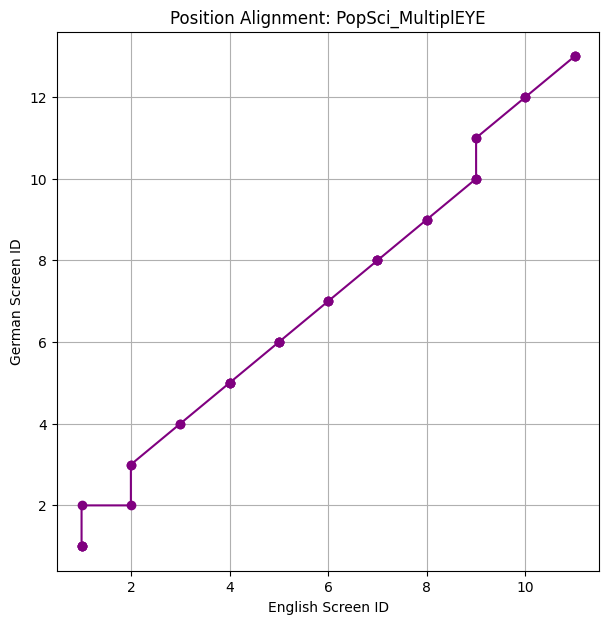

Ins_HumanRights
0 -> ['Universal -> Allgemeine', 'Declaration -> Erklärung', 'of -> der', 'Human -> Menschenrechte', 'Rights -> Menschenrechte', '- -> -', 'Preamble -> Präambel']
1 -> ['Whereas -> der', 'recognition -> Anerkennung', 'of -> von', 'the -> der', 'inherent -> angeborenen', 'dignity -> Anerkennung', 'and -> und', 'of -> von']
2 -> ['Whereas -> daß', 'disregard -> Verachtung', 'and -> und', 'contempt -> Verachtung', 'for -> zu', 'human -> Menschen', 'rights -> Menschenrechte', 'have -> haben,']
Proportion of screens that begin with the same text passage = 100.0%
Overall similarity of screen segmentation = 100.0%


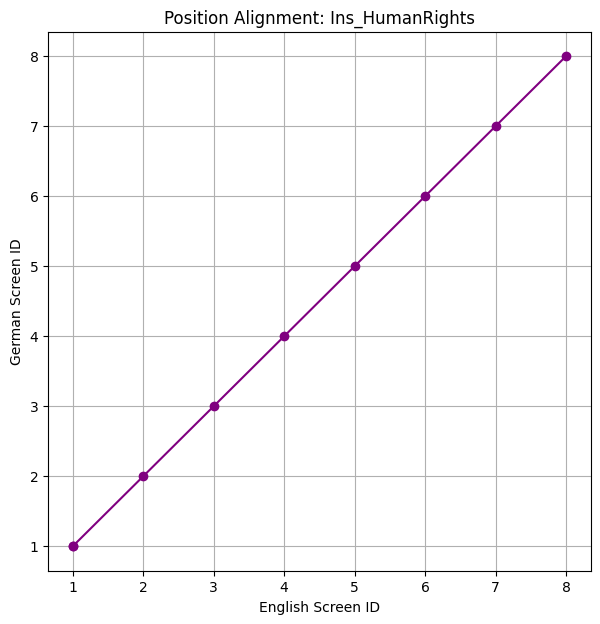

Ins_LearningMobility
0 -> ['REPORT -> KOMMISSION', 'FROM -> DER', 'THE -> DER', 'COMMISSION -> KOMMISSION', 'TO -> DER', 'THE -> DER', 'COUNCIL: -> KOMMISSION']
1 -> ['Progress -> Fortschrittsbericht', 'report -> Fortschrittsbericht', 'on -> über', 'a -> eine', 'Learning -> Lernmobilität', 'Mobility -> Lernmobilität', 'Benchmark -> Benchmark']
2 -> ['1. -> 1.']
Proportion of screens that begin with the same text passage = 66.67%
Overall similarity of screen segmentation = 77.78%


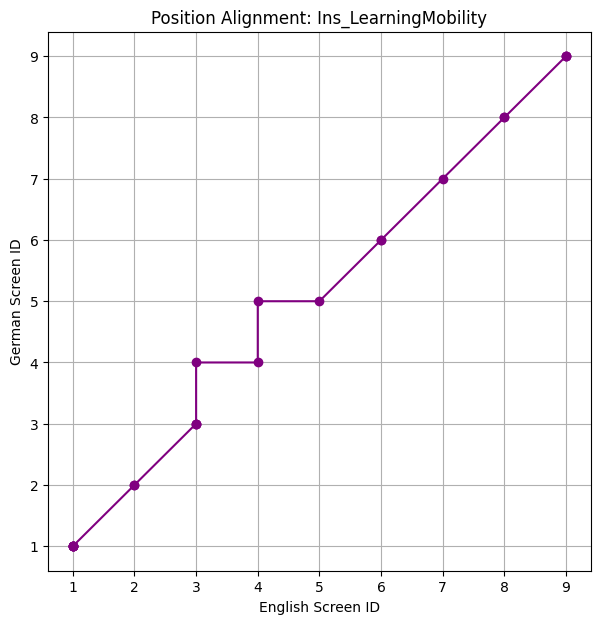

Lit_Alchemist
0 -> ['The -> Der', 'Alchemist -> Alchemist', '- -> -', 'Chapter -> Kapitel', '1 -> 1']
1 -> ['The -> Der', 'boy’s -> hieß', 'name -> hieß', 'was -> hieß', 'Santiago. -> Santiago.']
2 -> ['Dusk -> dämmern,', 'was -> er', 'falling -> dämmern,', 'as -> als', 'the -> an', 'boy -> einer', 'arrived -> bereits', 'with -> mit']
Proportion of screens that begin with the same text passage = 40.0%
Overall similarity of screen segmentation = 79.76%


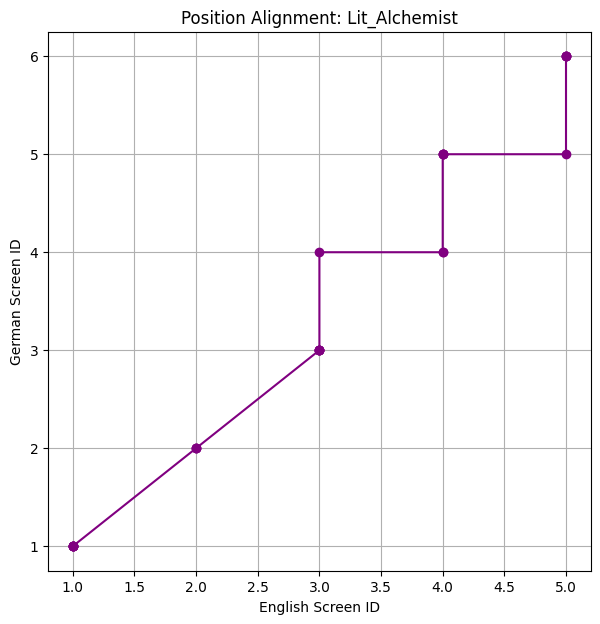

Lit_MagicMountain
0 -> ['The -> Der', 'Magic -> Zauberberg', 'Mountain -> Zauberberg', '- -> -', 'Foreword -> Vorsatz']
1 -> ['The -> der', 'story -> Geschichte', 'of -> in', 'Hans -> Hans', 'Castorp, -> Castorps,', 'which -> daß', 'we -> wir', 'would -> sollte,']
2 -> ['That -> Das', 'should -> wäre', 'be -> wäre', 'no -> kein', 'drawback -> Nachteil', 'to -> für', 'a -> eine', 'story, -> Geschichte,']
Proportion of screens that begin with the same text passage = 100.0%
Overall similarity of screen segmentation = 100.0%


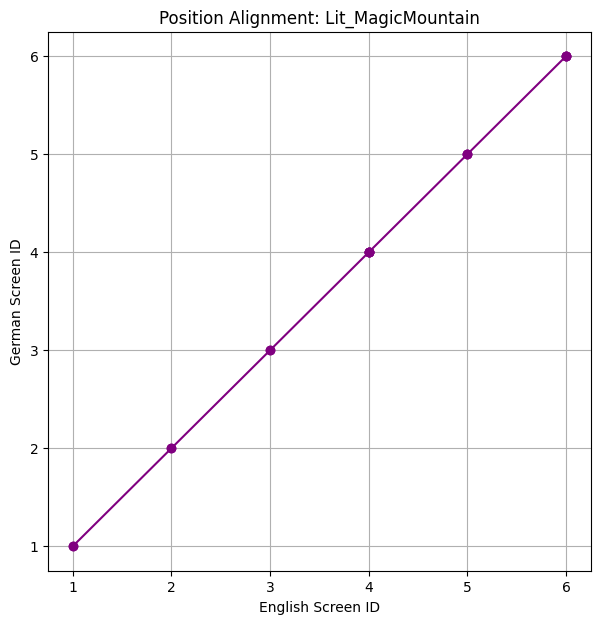

Lit_NorthWind
0 -> ['The -> Der', 'North -> Nordwind', 'Wind -> Nordwind', 'and -> und', 'the -> Der', 'Sun -> Sonne']
1 -> ['The -> der', 'North -> Nordwind', 'Wind -> Nordwind', 'and -> und', 'the -> der', 'Sun -> Sonne,', 'were -> wäre,', 'arguing -> stritten']
2 -> ['They -> Sie', 'agreed -> einig,', 'that -> dass', 'whoever -> derjenige', 'got -> wurden', 'the -> den', 'traveler -> Wanderer', 'to -> für']
Proportion of screens that begin with the same text passage = 100.0%
Overall similarity of screen segmentation = 50.0%


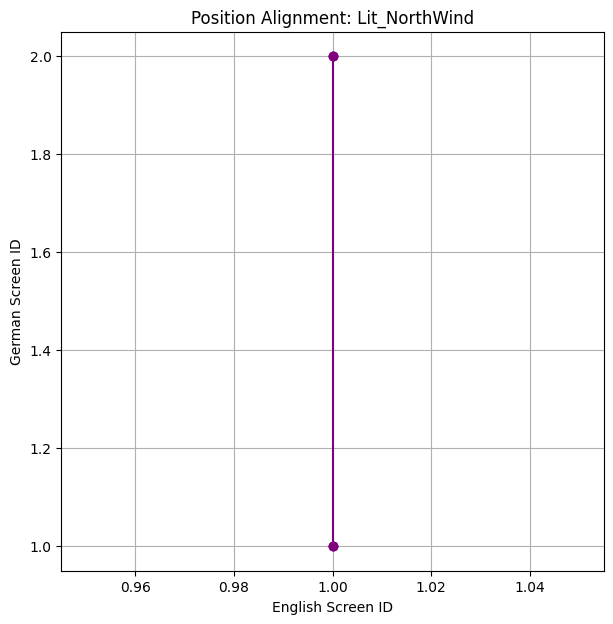

Lit_Solaris
0 -> ['Solaris -> Solaris', '- -> -', 'Chapter -> Kapitel', '2: -> 2:', 'The -> Die', 'Solarists -> Solaris']
1 -> ['The -> der', 'discovery -> Entdeckung', 'of -> der', 'Solaris -> Solaris', 'dated -> erfolgte', 'from -> der', 'about -> nahezu', '100 -> hundert']
2 -> ['The -> Der', 'planet -> Planet', 'orbits -> kreist', 'two -> zwei', 'suns: -> Sonnen,', 'a -> eine', 'red -> rote', 'sun -> Sonnen,']
Proportion of screens that begin with the same text passage = 85.71%
Overall similarity of screen segmentation = 88.69%


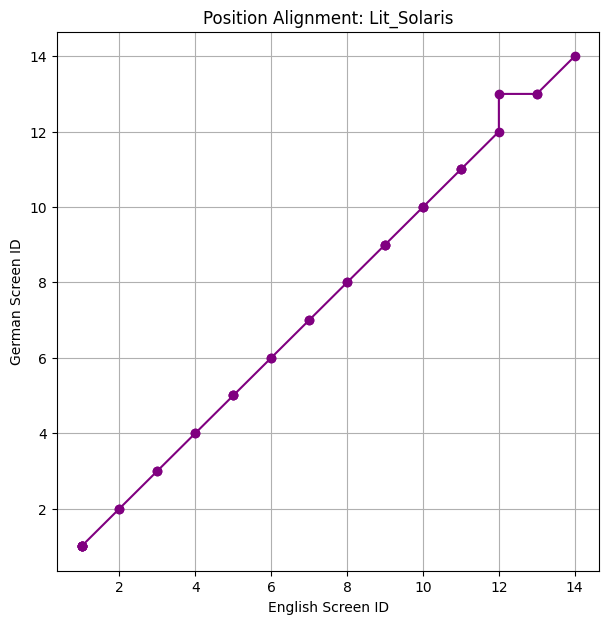

Lit_BrokenApril
0 -> ['Broken -> zerrissene', 'April -> April', '- -> -', 'Chapter -> Kapitel', '3 -> 3']
1 -> ['Holding -> Hand', 'his -> seiner', 'wife’s -> Frau', 'hand, -> Hand', 'Bessian -> Besian', 'Vorpsi -> Vorpsi', 'moved -> entschwunden', 'his -> seiner']
2 -> ['Now, -> ihnen,', 'before -> vor', 'them -> ihnen,', 'and -> und', 'on -> und', 'either -> noch', 'side -> neben', 'there -> sich']
Proportion of screens that begin with the same text passage = 80.0%
Overall similarity of screen segmentation = 75.5%


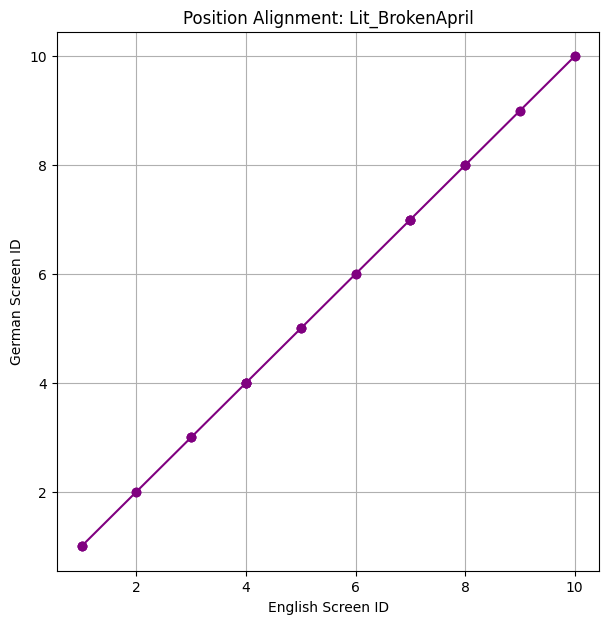

Arg_PISACowsMilk
0 -> ["Cow's -> Kuhmilch", 'Milk -> Kuhmilch', '- -> -', 'Introduction -> Einleitung']
1 -> ['In -> in', 'some -> einigen', 'places, -> Orten,', 'like -> in', 'the -> den', 'United -> USA,', 'States, -> USA,', 'drinking -> trinken.']
2 -> ['Imagine -> vor,', 'that -> den', 'three -> drei', 'students, -> Schüler,', 'Anna, -> Anna,', 'Christopher -> Christopher', 'and -> und', 'Sam, -> Sam,']
Proportion of screens that begin with the same text passage = 100.0%
Overall similarity of screen segmentation = 82.57%


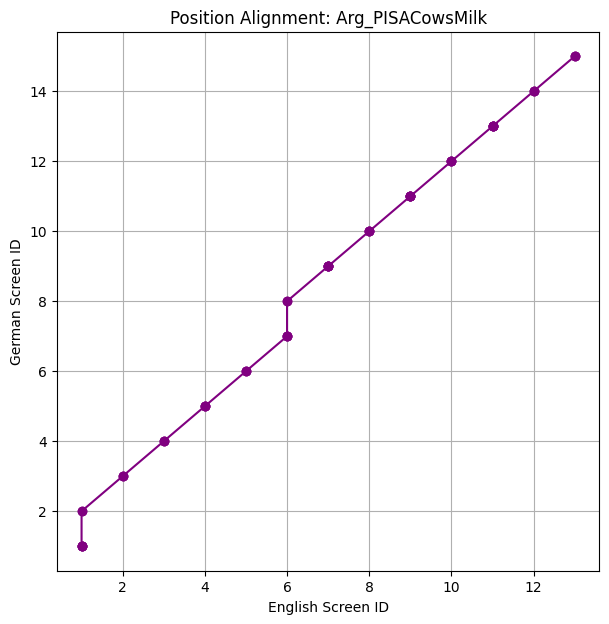

Arg_PISARapaNui
0 -> ['Rapa -> Die', 'Nui -> Die', '- -> -', 'Introduction -> Einleitung']
1 -> ['Imagine -> vor,', 'that -> dass', 'a -> eine', 'local -> örtliche', 'library -> Bibliothek', 'is -> dass', 'hosting -> örtliche', 'a -> eine']
2 -> ['The -> Der', 'lecture -> Vortrag', 'will -> wird', 'be -> wird', 'given -> wird', 'by -> von', 'a -> einer', 'professor -> Professorin']
Proportion of screens that begin with the same text passage = 100.0%
Overall similarity of screen segmentation = 96.7%


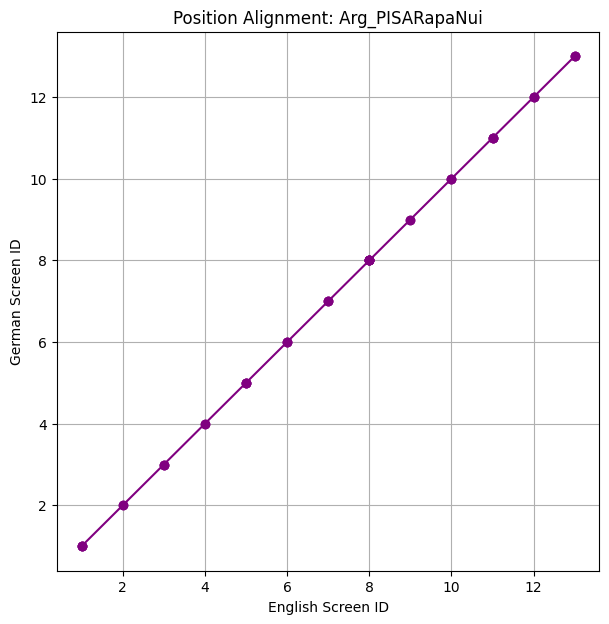

PopSci_Caveman
0 -> ['Swarthy -> blauäugiger', 'Blue-Eyed -> blauäugiger', 'Caveman -> Höhlenmensch', 'Revealed -> enthüllt']
1 -> ['DNA -> DNA,', 'taken -> extrahiert', 'from -> in', 'the -> den', 'wisdom -> Weisheitszahn', 'tooth -> den', 'of -> den', 'a -> einen']
2 -> ['The -> Dieser', 'Mesolithic -> mesolithische', 'man, -> Mann,', 'who -> wie', 'lived -> lebte,', 'in -> in', 'Spain -> Spanien', 'around -> etwa']
Proportion of screens that begin with the same text passage = 100.0%
Overall similarity of screen segmentation = 100.0%


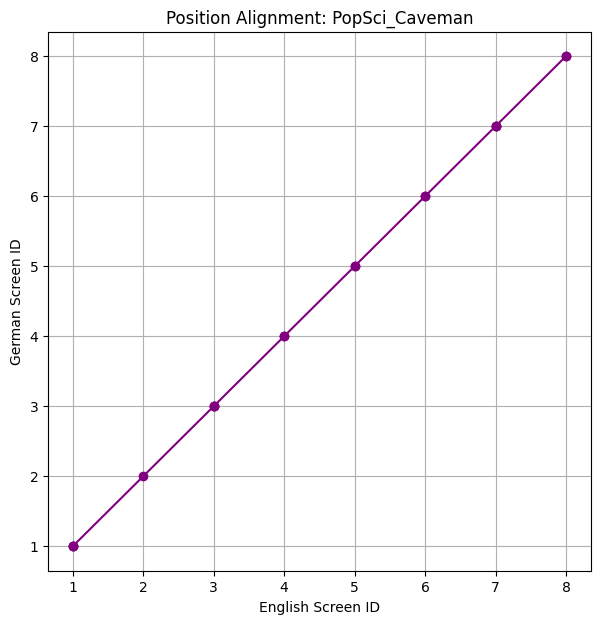

Enc_WikiMoon
0 -> ['Moon -> Mond']
1 -> ['https://en.wikipedia.org/wiki/Moon -> https://de.wikipedia.org/wiki/Mond']
2 -> ['From -> der', 'Wikipedia, -> Wikipedia,', 'the -> der', 'free -> freien', 'encyclopedia -> Enzyklopädie']
Proportion of screens that begin with the same text passage = 100.0%
Overall similarity of screen segmentation = 91.67%


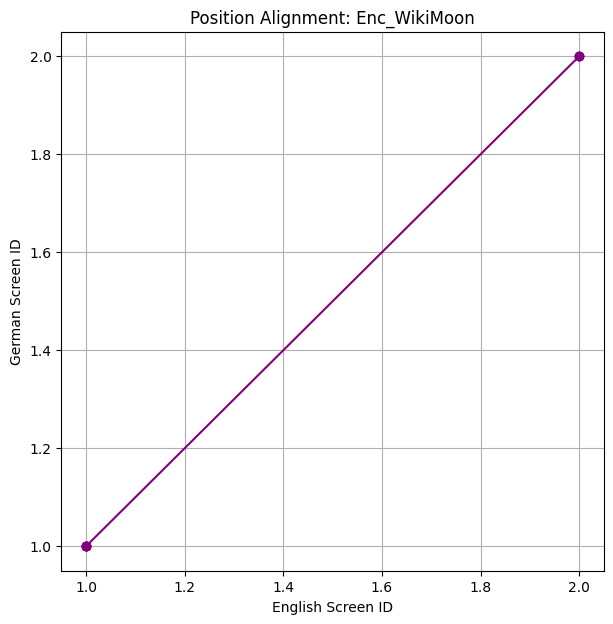

Average screens that begin with the same text passage = 88.6075%
Average similarity of screen segmentation = 85.7275%


In [18]:
similarity_scores = []
alignment_scores = []

for stimulus in stimuli:
    print(stimulus)
    df_en, df_OTHER, emb_en, emb_OTHER = get_stimulus_embeds(df_en_all, df_OTHER_all, stimulus)
    df_en2, df_OTHER2, alignment_map = get_alignment(df_en, df_OTHER, emb_en, emb_OTHER)

    sample_count = 0
    for en_idx, other_idx in alignment_map.items():
        if sample_count >= 3: break

        en_sent = df_en2.loc[en_idx, 'text']
        other_sent = df_OTHER2.loc[other_idx, 'text']
        pairs = get_word_pairs(en_sent, other_sent, model)

        print(str(en_idx) + ' -> ' + str(pairs[:8]))
        sample_count += 1

    similarity_score = screen_similarity(df_en2, df_OTHER2, alignment_map)
    alignment_score = screen_segmentation(df_en2, df_OTHER, alignment_map)

    similarity_scores.append(similarity_score)
    alignment_scores.append(alignment_score)

    print('Proportion of screens that begin with the same text passage = ' + str(similarity_score) + '%')
    print('Overall similarity of screen segmentation = ' + str(alignment_score) + '%')
    plot_alignment(df_en2, stimulus)

avg_similarity = sum(similarity_scores) / len(similarity_scores)
avg_alignment = sum(alignment_scores) / len(alignment_scores)

print('Average screens that begin with the same text passage = ' + str(avg_similarity) + '%')
print('Average similarity of screen segmentation = ' + str(avg_alignment) + '%')

In [23]:
import plotly.graph_objects as go
import plotly.io as pio

def create_plotly_fig(df_en, stimulus_name):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df_en['screen_id'],
        y=df_en['aligned_OTHER_screen'],
        mode='lines+markers',
        name='Alignment',
        line=dict(color='purple', width=3),
        marker=dict(size=8)
    ))

    max_val = max(df_en['screen_id'].max(), df_en['aligned_OTHER_screen'].max())
    fig.add_trace(go.Scatter(
        x=[1, max_val], y=[1, max_val],
        mode='lines',
        name='Ideal Diagonal',
        line=dict(color='gray', dash='dash', width=1),
        hoverinfo='skip'
    ))

    fig.update_layout(
        title=f"Alignment: {stimulus_name}",
        xaxis_title="English Screen ID",
        yaxis_title= OTHER + " Screen ID",
        template="plotly_white",
        height=500,
        hovermode="x unified"
    )
    return fig

In [21]:
html_content = """
<html>
<head>
    <title>MultiplEYE Alignment Report</title>
    <style>
        body { font-family: sans-serif; max-width: 1000px; margin: auto; padding: 20px; }
        .card { border: 1px solid #ddd; padding: 20px; margin-bottom: 30px; border-radius: 8px; box-shadow: 0 2px 5px rgba(0,0,0,0.1); }
        .stats { background: #f9f9f9; padding: 10px; border-radius: 5px; margin-bottom: 10px; }
        h1 { text-align: center; color: #333; }
        .toc { background: #eee; padding: 15px; margin-bottom: 20px; border-radius: 5px; }
        .toc a { display: inline-block; margin-right: 15px; text-decoration: none; color: #007bff; }
    </style>
</head>
<body>
    <h1>Alignment Analysis Report</h1>
    <div class="toc"><strong>Jump to:</strong>
"""

article_blocks = []

print("Generating")

for stimulus in stimuli:
    print(f"Processing {stimulus}")

    df_en, df_OTHER, emb_en, emb_OTHER = get_stimulus_embeds(df_en_all, df_OTHER_all, stimulus)

    if df_en['screen_id'].nunique() == 1 and df_OTHER['screen_id'].nunique() == 1:
        sim_score = 100.0
        align_score = 100.0
        df_en['aligned_OTHER_screen'] = 1
    else:
        df_en2, df_OTHER2, alignment_map = get_alignment(df_en, df_OTHER, emb_en, emb_OTHER)
        df_en = df_en2
        sim_score = screen_similarity(df_en2, df_OTHER2, alignment_map)
        align_score = screen_segmentation(df_en2, df_OTHER, alignment_map)

    fig = create_plotly_fig(df_en, stimulus)
    plot_html = fig.to_html(full_html=False, include_plotlyjs='cdn')

    block = f"""
    <div class="card" id="{stimulus}">
        <h2>{stimulus}</h2>
        <div class="stats">
            <strong>Start Similarity:</strong> {sim_score}% |
            <strong>Content Overlap:</strong> {align_score}%
        </div>
        {plot_html}
    </div>
    """
    article_blocks.append(block)

    html_content += f'<a href="#{stimulus}">{stimulus}</a>'

html_content += "</div>" + "\n".join(article_blocks) + "</body></html>"

with open("alignment_report.html", "w", encoding="utf-8") as f:
    f.write(html_content)

print("done")

Generating Website...
Processing PopSci_MultiplEYE...
Processing Ins_HumanRights...
Processing Ins_LearningMobility...
Processing Lit_Alchemist...
Processing Lit_MagicMountain...
Processing Lit_NorthWind...
Processing Lit_Solaris...
Processing Lit_BrokenApril...
Processing Arg_PISACowsMilk...
Processing Arg_PISARapaNui...
Processing PopSci_Caveman...
Processing Enc_WikiMoon...
done
